In [2]:

from mri_loader import MRI

import pandas as pd
import numpy as np



In [3]:
subject_id = 12

run_ids = list(range(1, 5))

(subject_id, run_ids)

(12, [1, 2, 3, 4])

In [4]:
dataset = [MRI(subject_id, run_id) for run_id in run_ids]

[mri.load() for mri in dataset]

dataset

In [5]:
dataset[0].labels["run time"].values /1000

array([6.00000e-02, 5.86300e+00, 1.02640e+01, 1.57670e+01, 2.04680e+01,
       2.55710e+01, 2.89720e+01, 3.37740e+01, 3.90760e+01, 4.35770e+01,
       5.47820e+01, 5.78840e+01, 6.37860e+01, 6.81710e+01, 7.21730e+01,
       7.70740e+01, 8.34600e+01, 8.72620e+01, 9.22470e+01, 9.78330e+01,
       1.02235e+02, 1.05937e+02, 1.11338e+02, 1.15240e+02, 1.21826e+02,
       1.29613e+02, 1.35815e+02, 1.39917e+02, 1.45719e+02, 1.49321e+02,
       1.53722e+02, 1.59824e+02, 1.63626e+02, 1.69429e+02, 1.74431e+02,
       1.77632e+02, 1.83235e+02, 1.88437e+02, 1.93838e+02, 1.98540e+02,
       2.03325e+02, 2.06627e+02, 2.12030e+02, 2.16831e+02, 2.21333e+02,
       2.26035e+02, 2.31537e+02, 2.36438e+02, 2.40441e+02, 2.46043e+02,
       2.55946e+02, 2.61249e+02, 2.65951e+02, 2.70253e+02, 2.75155e+02,
       2.78656e+02, 2.83741e+02, 2.88326e+02, 2.94429e+02, 2.98131e+02,
       3.02532e+02, 3.08635e+02, 3.12737e+02, 3.23541e+02, 3.27943e+02,
       3.31445e+02, 3.42649e+02, 3.47250e+02, 3.51252e+02, 3.554

In [6]:
images = []
times = []
labels = []

last_timestamp = 0

for run in dataset:
    images.append(run.data)

    """# not sure this mode works with GLM
    interpolated_time_mode = 0

    if interpolated_time_mode:
        times.append(run.mri_timestamps + last_timestamp)
        last_timestamp += run.mri_timestamps[-1]

        labels.append(run.mri_labels["morph level"].values)
    else:"""

    times.append(run.labels["run time"] + last_timestamp)
    last_timestamp += run.labels["run time"].values[-1]

    labels.append(run.labels["morph level"].values)




In [7]:
from nilearn.image import concat_imgs

images = concat_imgs(images)

In [8]:
times = np.concatenate(times) / 1000
labels = np.concatenate(labels)

In [9]:
times.shape

(365,)

In [10]:
labels.shape

(365,)

In [11]:
images.shape

(65, 77, 55, 816)

In [12]:
events = pd.DataFrame(
    {'onset': times,
     'trial_type': [str(v) for v in labels],
     'duration': 2.5}
)


In [13]:
from nilearn.plotting import plot_design_matrix


In [14]:
from nilearn.glm.first_level import FirstLevelModel


In [17]:

repetition_time = dataset[0]._t_r
fmri_glm = FirstLevelModel(t_r=repetition_time,
          drift_model='polynomial',
          drift_order=3,
          hrf_model='spm',
          mask_img=dataset[0].brain_mask,
          smoothing_fwhm=6,
          n_jobs=-1)



In [18]:

fmri_glm = fmri_glm.fit(images, events)


C:\Users\ducat\AppData\Local\Temp\ipykernel_16140\2469987523.py:1: UserWarning: Mean values of 0 observed. The data have probably been centered. Scaling might not work as expected.
  fmri_glm = fmri_glm.fit(images, events)


In [19]:
n_scans = images.shape[-1]
TR = repetition_time
total_scan_time = n_scans * TR

print("Total scan time (s):", total_scan_time)
print(events["onset"].describe())
print("Events after scan end:", (events["onset"] > total_scan_time).sum())
print("Events before 0:", (events["onset"] < 0).sum())
print("Unique trial_types:", events["trial_type"].nunique())

Total scan time (s): 1957.9979
count     365.000000
mean      938.651233
std       543.973030
min         0.060000
25%       470.568000
50%       943.210000
75%      1408.731000
max      1883.791000
Name: onset, dtype: float64
Events after scan end: 0
Events before 0: 0
Unique trial_types: 10


In [20]:

design_matrix = fmri_glm.design_matrices_[0]


contrast_matrix = np.eye(design_matrix.shape[1])
contrasts = {
    column: contrast_matrix[i]
    for i, column in enumerate(design_matrix.columns)
}

<Axes: label='conditions', ylabel='scan number'>

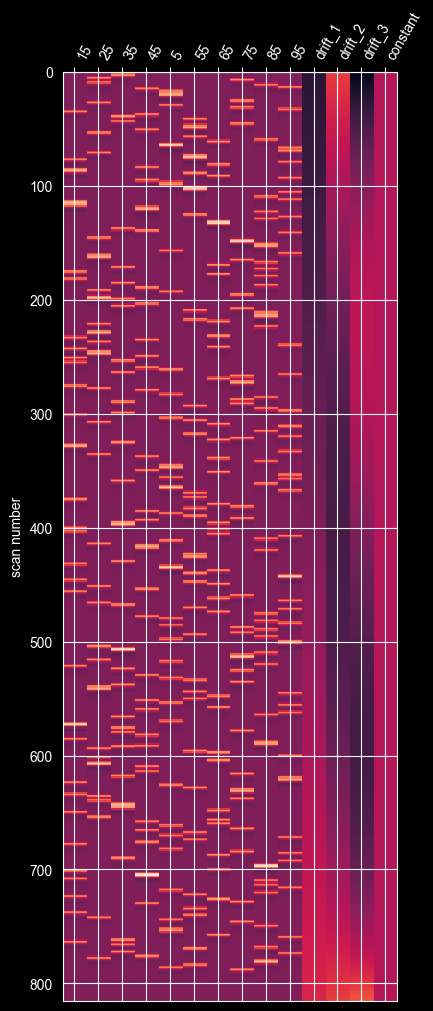

In [21]:
plot_design_matrix(design_matrix)


In [22]:
from stats import *


In [23]:
all_labels = pd.concat([ds.labels for ds in dataset], ignore_index=True)

cur_mean, cur_std = compute_morph_scores(all_labels)

_, fitted_curve = fit_sigmoid(cur_mean)


In [24]:
low_quartile = np.percentile(fitted_curve, 25)
low_inflexion = find_inflexion(fitted_curve, low_quartile)

high_quartile = np.percentile(fitted_curve, 75)
high_inflexion = find_inflexion(fitted_curve, high_quartile)

(low_inflexion, high_inflexion)

(np.float64(0.2743243243243243), np.float64(0.7247747747747747))

In [25]:

low_contrast_columns = []
high_contrast_columns = []

for key, column in contrasts.items():
    try:
        key_numeric = float(key) / 100

        if key_numeric < low_inflexion:
            low_contrast_columns.append(column)

        if key_numeric > high_inflexion:
            high_contrast_columns.append(column)
    except ValueError:
        continue



In [26]:
contrasts["low"] = np.sum(low_contrast_columns, axis=0)

contrasts["high"] = np.sum(high_contrast_columns, axis=0)


In [27]:
glm_contrast_val = contrasts["high"] - contrasts["low"]
glm_contrast_val

array([-1., -1.,  0.,  0., -1.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,
        0.])

In [28]:
z_score = fmri_glm.compute_contrast(glm_contrast_val, stat_type='t')

In [29]:
from nilearn.glm import threshold_stats_img
from nilearn.plotting import plot_stat_map


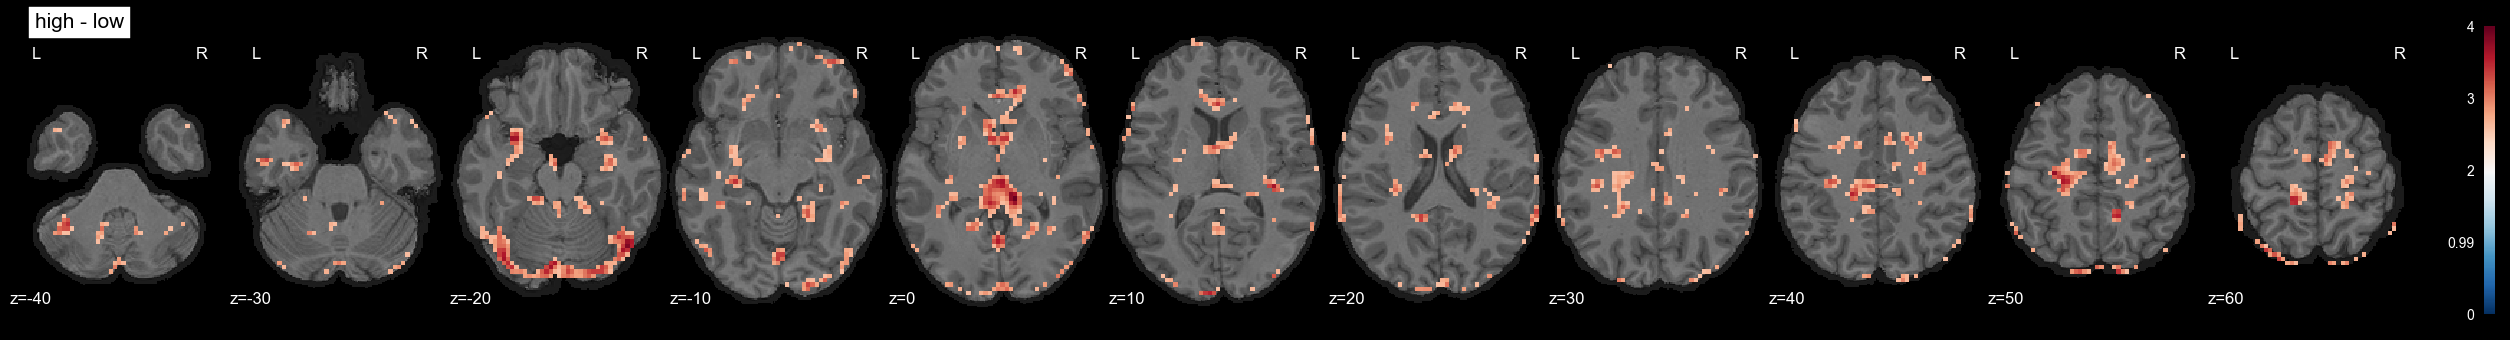

In [30]:
clean_z, threshold = threshold_stats_img(z_score, alpha=0.01, height_control="fpr")

plot_stat_map(
    clean_z,
    display_mode="z",
    title="high - low",
    cut_coords=np.arange(-40, 70, 10),
    bg_img=dataset[0].background,
    black_bg=True,
)

In [31]:
threshold

np.float64(2.575829303548901)

In [32]:
from nilearn import plotting



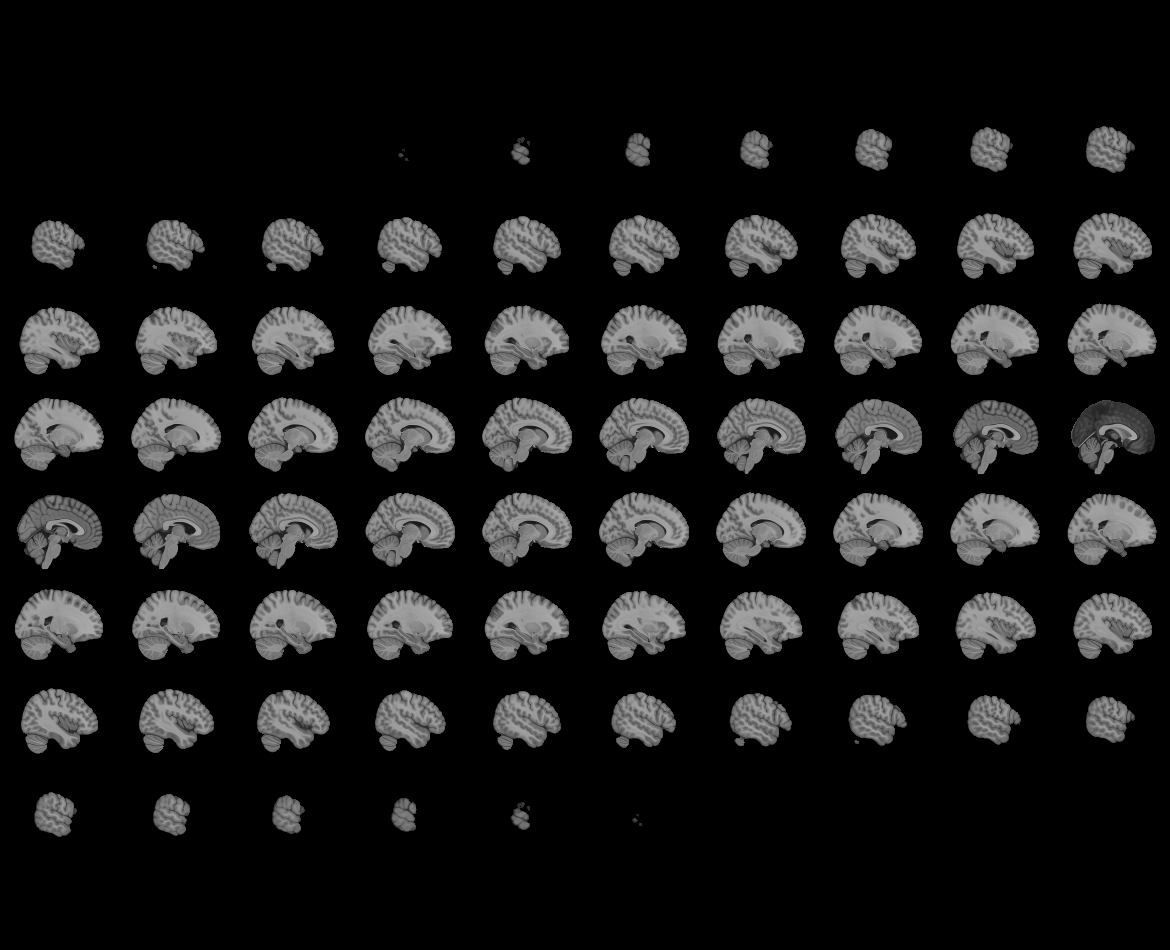
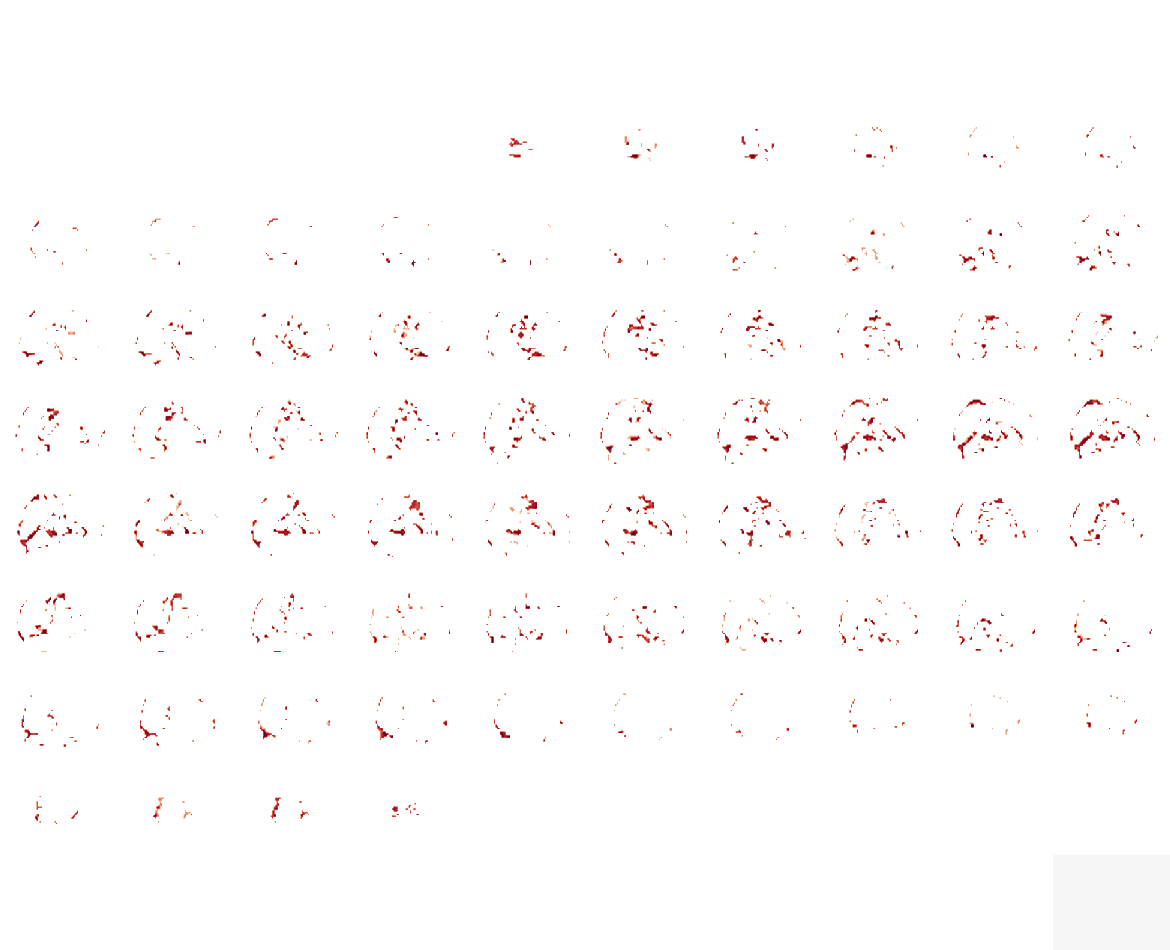

In [33]:
plotting.view_img(clean_z)


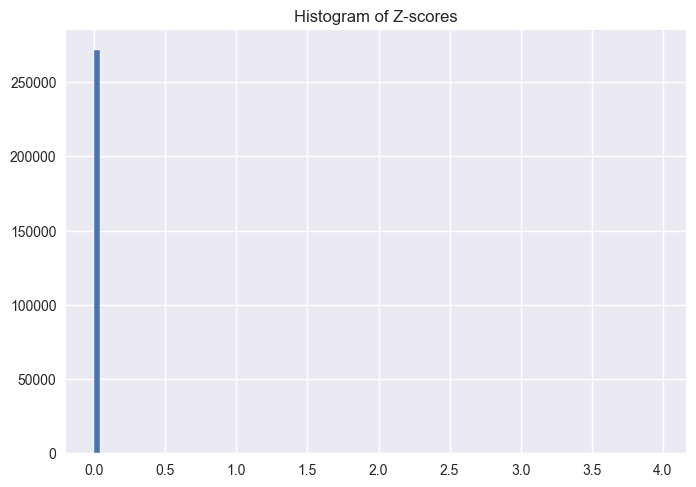

In [34]:
import numpy as np
import matplotlib.pyplot as plt

data = clean_z.get_fdata()
plt.hist(data.ravel(), bins=100)
plt.title("Histogram of Z-scores")
plt.show()

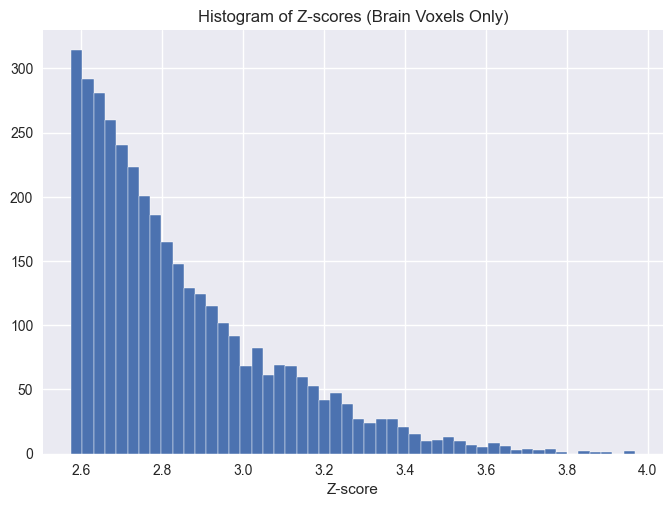

Min value: 2.576050106591386
Max value: 3.9676002108817214


In [35]:
from nilearn.masking import apply_mask
import matplotlib.pyplot as plt

mask = dataset[0].brain_mask

masked_data = apply_mask(clean_z, mask)
masked_data = masked_data[masked_data > 0.5]

plt.hist(masked_data, bins=50)
plt.title("Histogram of Z-scores (Brain Voxels Only)")
plt.xlabel("Z-score")
plt.show()

print(f"Min value: {masked_data.min()}")
print(f"Max value: {masked_data.max()}")


In [36]:
import numpy as np

contrast_val = np.array([ 1.,  1.,  0.,  0.,  1.,  0.,  0., -1., -1., -1.,  0.,  0.,  0., 0.])

contrast_val = np.squeeze(contrast_val)

print(contrast_val)

z_map = fmri_glm.compute_contrast(contrast_val, stat_type='t')

from nilearn.masking import apply_mask
#masked_data = apply_mask(z_map, dataset[0].brain_mask)

print(f"Min: {masked_data.min()}")
print(f"Max: {masked_data.max()}")


[ 1.  1.  0.  0.  1.  0.  0. -1. -1. -1.  0.  0.  0.  0.]
Min: 2.576050106591386
Max: 3.9676002108817214


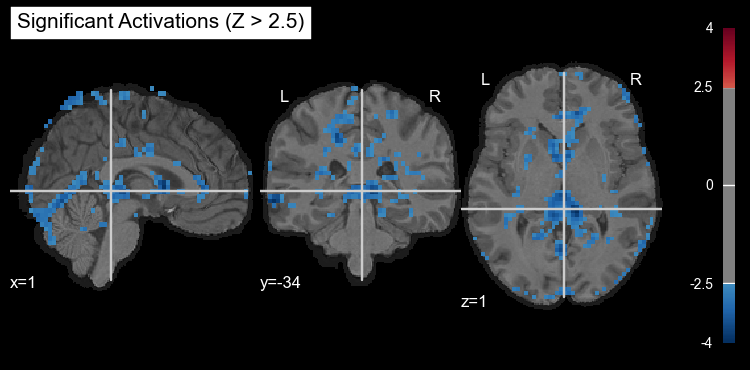

In [39]:
plot_stat_map(z_map,
              bg_img=dataset[0].background,
              threshold=2.5,
              title="Significant Activations (Z > 2.5)",
              colorbar=True)

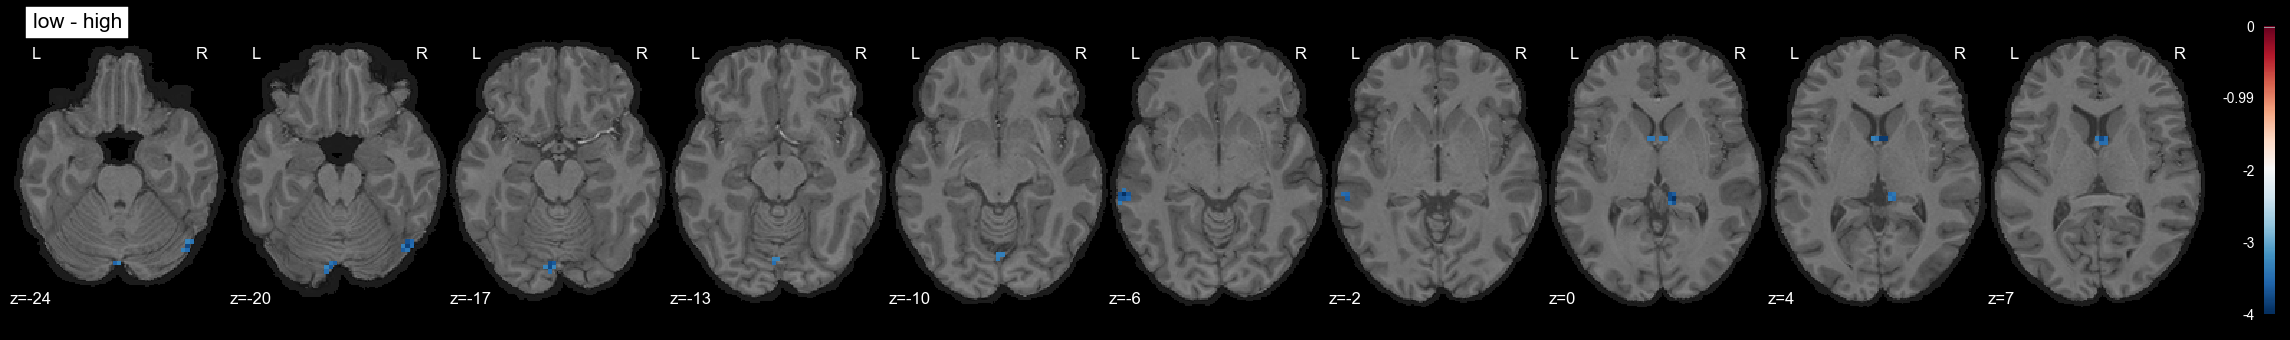

In [38]:
clean_z, threshold = threshold_stats_img(z_map, alpha=0.001, height_control="fpr", cluster_threshold=10)

plot_stat_map(
    clean_z,
    bg_img=dataset[0].background,
    display_mode="z",
    title="low - high",
    cut_coords=10,
    black_bg=True,
)

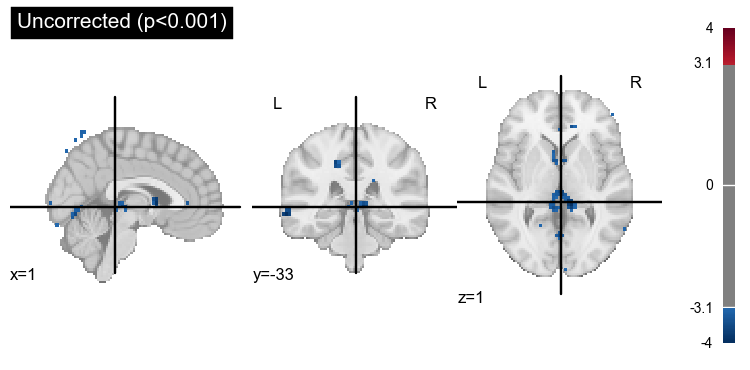

In [123]:
plot_stat_map(z_map,
              threshold=3.1,
              title="Uncorrected (p<0.001)")

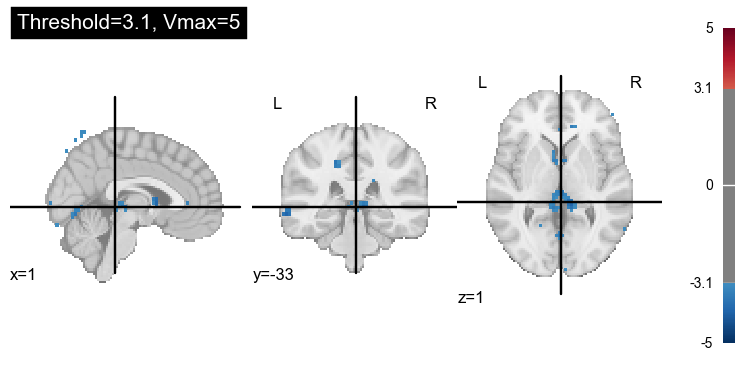

In [124]:
plot_stat_map(z_map,
              threshold=3.1,
              vmax=5.0,        # Force the color scale to go up to 5
              colorbar=True,
              title="Threshold=3.1, Vmax=5")


In [125]:
import numpy as np

# Get the data inside the brain
data = z_map.get_fdata()
masked_data = data[data != 0] # Ignore outside air

# Count how many voxels are significant
total_voxels = len(masked_data)
significant_voxels = np.sum(masked_data > 3.1)
percent_active = (significant_voxels / total_voxels) * 100

print(f"Total brain voxels: {total_voxels}")
print(f"Voxels above 3.1:   {significant_voxels}")
print(f"Percentage of brain active: {percent_active:.2f}%")


Total brain voxels: 58843
Voxels above 3.1:   0
Percentage of brain active: 0.00%


In [130]:
from nilearn.glm import threshold_stats_img

# Let nilearn calculate the threshold
thresholded_map, calculated_threshold = threshold_stats_img(
    z_map,
    alpha=0.5,
    height_control='fdr' # or 'bonferroni'
)

print(f"Manual Uncorrected Threshold: 3.1")
print(f"Calculated Corrected Threshold: {calculated_threshold}")


Manual Uncorrected Threshold: 3.1
Calculated Corrected Threshold: 0.71471993241327
